In [ ]:
pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 44.5 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

In [ ]:
# --------------------------------------------------
# 1. Define a circuit
# --------------------------------------------------

def circuit_1(params, n_qubits):
    idx = 0

    # Layer 1: RY
    for i in range(n_qubits):
        qml.RY(params[idx], wires=i)
        idx += 1

    # Circular CRZ
    for i in range(n_qubits):
        qml.CRZ(params[idx], wires=[i, (i+1) % n_qubits])
        idx += 1

    # Layer 2: RY
    for i in range(n_qubits):
        qml.RY(params[idx], wires=i)
        idx += 1

    # Second Circular CRZ
    for i in range(n_qubits):
        qml.CRZ(params[idx], wires=[i, (i+1) % n_qubits])
        idx += 1


def param_count(n):
    return 4*n


In [ ]:

# --------------------------------------------------
# 2. Print the circuit
# --------------------------------------------------

n_qubits = 3
n_params = param_count(n_qubits)


dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def draw_circuit(params):
    circuit_1(params, n_qubits)
    return qml.state()

params = np.random.uniform(0, 2*np.pi, n_params)

print(qml.draw(draw_circuit)(params))


0: ──RY(1.11)─╭●──────────────────╭RZ(1.31)──RY(6.10)─╭●──────────────────╭RZ(3.61)─┤  State
1: ──RY(2.18)─╰RZ(0.61)─╭●────────│──────────RY(5.51)─╰RZ(2.19)─╭●────────│─────────┤  State
2: ──RY(6.12)───────────╰RZ(4.55)─╰●─────────RY(0.13)───────────╰RZ(4.98)─╰●────────┤  State


In [ ]:
# --------------------------------------------------
# 3. Expressibility calculation
# --------------------------------------------------

def js_divergence(p, q):
    p = np.array(p) + 1e-10
    q = np.array(q) + 1e-10
    m = 0.5 * (p + q)
    return 0.5 * (entropy(p, m) + entropy(q, m))


def calculate_expressibility(n_samples=2000):

    fidelities = []

    for _ in range(n_samples):
        p1 = np.random.uniform(0, 2*np.pi, n_params)
        p2 = np.random.uniform(0, 2*np.pi, n_params)

        state1 = draw_circuit(p1)
        state2 = draw_circuit(p2)

        fidelity = np.abs(np.vdot(state1, state2))**2
        fidelities.append(fidelity)

    # Histogram
    hist, bins = np.histogram(fidelities, bins=50, density=True)
    bin_width = bins[1] - bins[0]
    hist = hist * bin_width

    # Haar distribution
    N = 2**n_qubits
    haar_probs = []
    for i in range(len(bins)-1):
        l, u = bins[i], bins[i+1]
        prob = (1-l)**(N-1) - (1-u)**(N-1)
        haar_probs.append(prob)

    haar_probs = np.array(haar_probs)
    haar_probs /= np.sum(haar_probs)

    expressibility = js_divergence(hist, haar_probs)

    # Plot
    plt.figure(figsize=(7,5))
    plt.hist(fidelities, bins=50, density=True, alpha=0.6, label="Circuit")

    mid = (bins[:-1] + bins[1:]) / 2
    haar_density = (N-1)*(1-mid)**(N-2)
    plt.plot(mid, haar_density, 'r', lw=2, label="Haar")

    plt.title(f"Expressibility = {expressibility:.5f}")
    plt.xlabel("Fidelity")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return expressibility

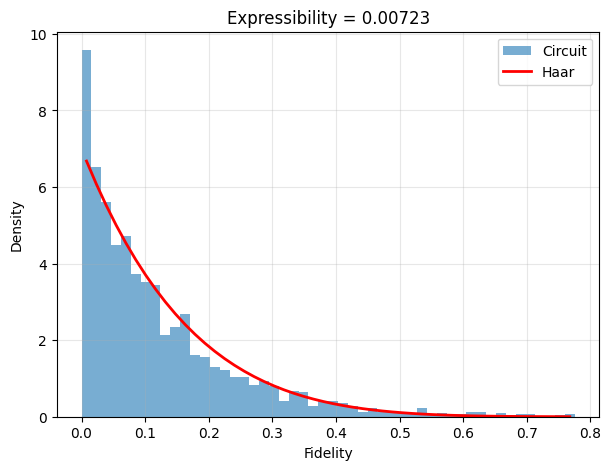


Expressibility (JS Divergence): 0.007226597051220431


In [ ]:
# --------------------------------------------------
# 4. Run
# --------------------------------------------------

expr = calculate_expressibility(n_samples=2000)

print("\nExpressibility (JS Divergence):", expr)
